# Identifying Entities in Healthcare Data

## Problem Statement
‘BeHealthy’ aims to connect the medical communities with millions of patients across the country. 
‘BeHealthy’ has a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicines online. Here, doctors can easily organise appointments, track past medical records and provide e-prescriptions.
You have been given such a data set in which a lot of text is written related to the medical domain. 
As you can see in the dataset, there are a lot of diseases that can be mentioned in the entire dataset and their related treatments are also mentioned implicitly in the text.
You need to build a custom NER to get the list of diseases and their treatment from the dataset.


In this assignment, you need to perform the following broad steps:
* You need to process and modify the data into sentence format. This step has to be done for the 'train_sent' and ‘train_label’ datasets and for test datasets as well.
* After that, you need to define the features to build the CRF model.
* Then, you need to apply these features in each sentence of the train and the test dataset to get the feature values.
* Once the features are computed, you need to define the target variable and then build the CRF model.
* Then, you need to perform the evaluation using a test data set.
* After that, you need to create a dictionary in which diseases are keys and treatments are values.

There are eight major tasks that you need to perform to complete the assignment. They are as follows:
1. Data preprocessing
2. Concept identification
3. Defining the features for CRF
4. Getting the features words and sentences
5. Defining input and target variables
6. Building the model
7. Evaluating the model
8. Identifying the diseases and predicted treatment using a custom NER

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
import sklearn_crfsuite

from sklearn_crfsuite import metrics, CRF
from sklearn.model_selection import train_test_split
from spacy import displacy

model = spacy.load("en_core_web_sm")

2023-06-18 11:00:28.706059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


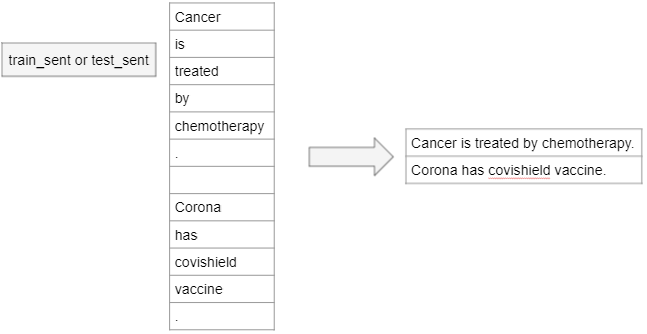

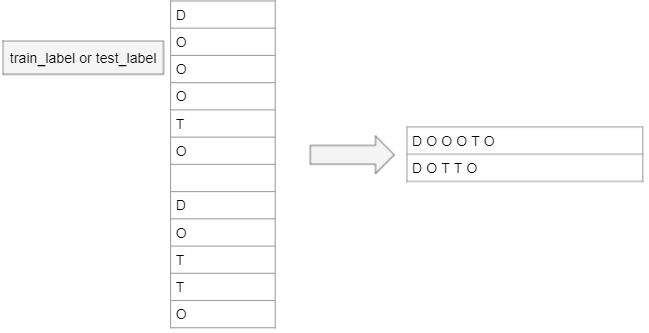

##### Function to read from the filename and return data after cleanup for \n

In [3]:
def file_read(filename):
    data = []
    with open(filename, "r") as fp:
        data = fp.read()
        data = data.replace("\n\n", "##").replace("\n", " ").replace("##", "\n")
    return data

In [4]:
train_sent   = file_read('./train_sent')
train_label = file_read('./train_label')
test_sent    = file_read('./test_sent')
test_label = file_read('./test_label')

In [5]:
train_sent_processed = train_sent.splitlines()
test_sent_processed = test_sent.splitlines()
train_label_processed = train_label.splitlines()
test_label_processed = test_label.splitlines()

##### Just checking the processed content for first 5 statements

In [6]:
print("First 5 processed sentence from training dataset-")
for i in range(5):
    print(train_sent_processed[i])

print("\n" + "First 5 processed sentence from testing dataset-")
for i in range(5):
    print(test_sent_processed[i])
    
print("\n" + "First 5 processed sentence from training label-")
for i in range(5):
    print(train_label_processed[i])
    
print("\n" + "First 5 processed sentence from training dataset-")
for i in range(5):
    print(test_label_processed[i])

First 5 processed sentence from training dataset-
All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )

First 5 processed sentence from testing dataset-
Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9

##### Checking the number of sentence and labels

In [7]:
print("Number of train sentence: ", len(train_sent_processed))
print("Number of test sentence: ", len(test_sent_processed))
print("Number of train label: ", len(train_label_processed))
print("Number of test label: ", len(test_label_processed))

Number of train sentence:  2599
Number of test sentence:  1056
Number of train label:  2599
Number of test label:  1056


##### Combined sentence and labels 

In [8]:
# Combined sentence set
all_sent = train_sent_processed + test_sent_processed
len(all_sent)
# Combined labels
all_labels = train_label_processed + test_label_processed
len(all_labels)

3655

##### Similarly, observe 3655 total labels in the entire given corpus

In [9]:
# dataframe
df=pd.DataFrame(list(zip(all_sent,all_labels)), columns=['sentences','labels'])
df.head()

,sentences,labels
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.

##### Extracting tokens which have NOUN or PROPN as their PoS tag and finding their frequency-

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
# Creating empty Train and Test dataframes for POS, Lemma tagging along with Labels 
train_df = pd.DataFrame(columns=['SENTENCE','WORD','POS','LEMMA','LABEL'])
test_df = pd.DataFrame(columns=['SENTENCE','WORD','POS','LEMMA','LABEL'])

##### Tokenizing Train and Test Dataframe

In [12]:
nlp= spacy.load("en_core_web_sm")


In [13]:
# Tokenizing Train dataframe

i=0
j=0

# iterating against each sentence
for sent, label in zip(train_sent_processed, train_label_processed):
    i+=1
    # iterating for each word in a sentence
    for word, lbl in zip(sent.split(), label.split()):
        doc = nlp(word)
        for tokn in doc:
            train_df.loc[j,['SENTENCE','WORD','POS','LEMMA','LABEL']] = [i, tokn.text, tokn.pos_, tokn.lemma_, lbl]
            j+=1       

In [14]:
# Tokenizing Test dataframe

i=0
j=0

# iterating against each sentence
for sent, label in zip(test_sent_processed, test_label_processed):
    i+=1
    # for each word in a sentence
    for word,lbl in zip(sent.split(),label.split()):
        doc = nlp(word)
        for tokn in doc:
            test_df.loc[j,['SENTENCE','WORD','POS','LEMMA','LABEL']] = [i, tokn.text, tokn.pos_, tokn.lemma_, lbl]
            j+=1

In [15]:
# Concatenating TRAIN and TEST dataframes
data_df = pd.concat((train_df, test_df), axis=0)
# Resetting index
data_df.reset_index(inplace=True, drop=True)

##### Top 25 most common tokens with NOUN or PROPN PoS tags

In [16]:
top_25_token = data_df[(data_df['POS'] == 'NOUN') | ((data_df['POS'] == 'PROPN'))]['WORD'].value_counts()[:25]
print(top_25_token)

WORD
patients        492
treatment       281
cancer          200
therapy         175
disease         143
cell            140
lung            116
group            94
gene             88
chemotherapy     88
effects          85
results          79
women            77
patient          75
TO_SEE           75
surgery          71
risk             71
cases            71
analysis         70
human            67
rate             67
response         66
survival         65
children         64
effect           64
Name: count, dtype: int64


##### Plotting most frequent words for EDA

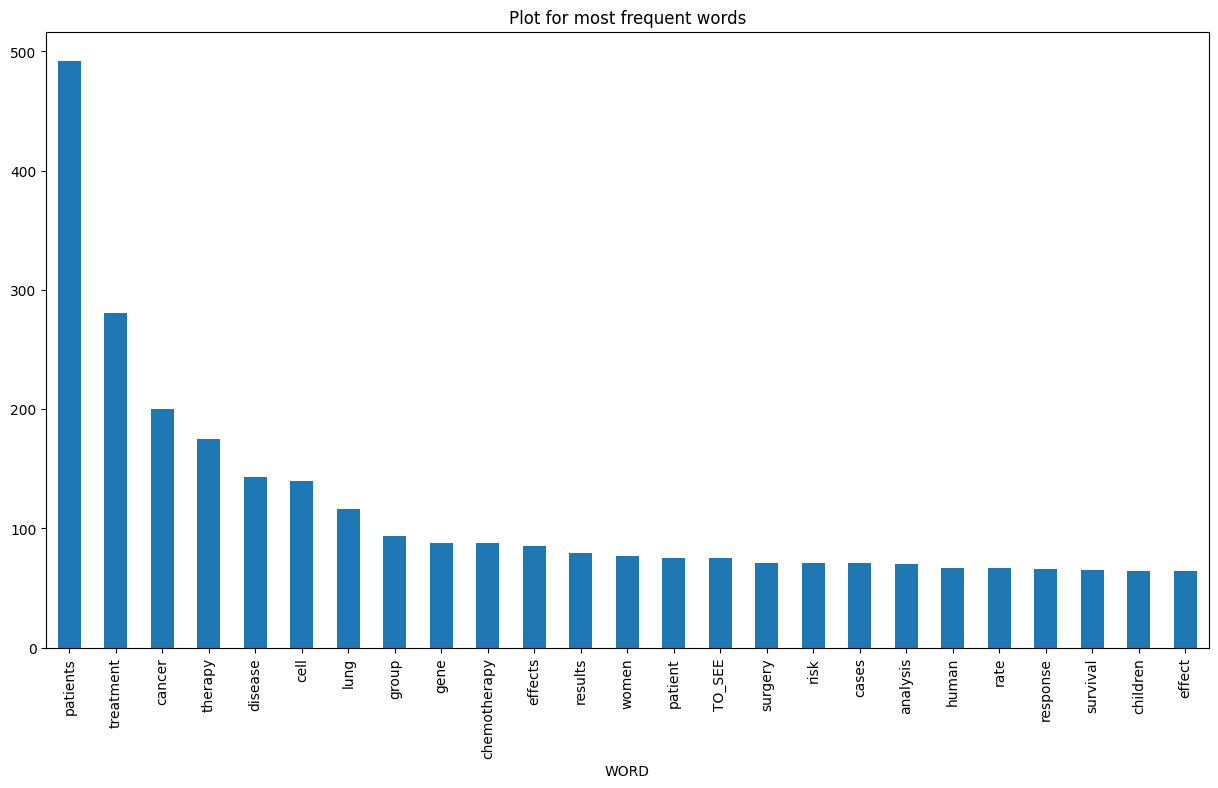

In [17]:
plt.figure(figsize=(15,8)) 
ax = top_25_token.plot.bar()
ax.set_title('Plot for most frequent words')
plt.show()

##### Top 25 Lemma words with NOUN or PROPN PoS tags

In [18]:
top_25_lemma = data_df[(data_df['POS'] == 'NOUN') | ((data_df['POS'] == 'PROPN'))]['LEMMA'].value_counts()[:25]
print(top_25_lemma)

LEMMA
patient         587
treatment       316
cancer          226
cell            203
therapy         182
disease         172
effect          163
case            132
group           128
lung            120
result          118
gene            112
year            105
rate            102
trial            91
chemotherapy     91
woman            89
analysis         86
protein          82
response         81
risk             78
child            78
human            77
TO_SEE           75
mutation         75
Name: count, dtype: int64


##### Plotting most frequent lemmatized words for EDA

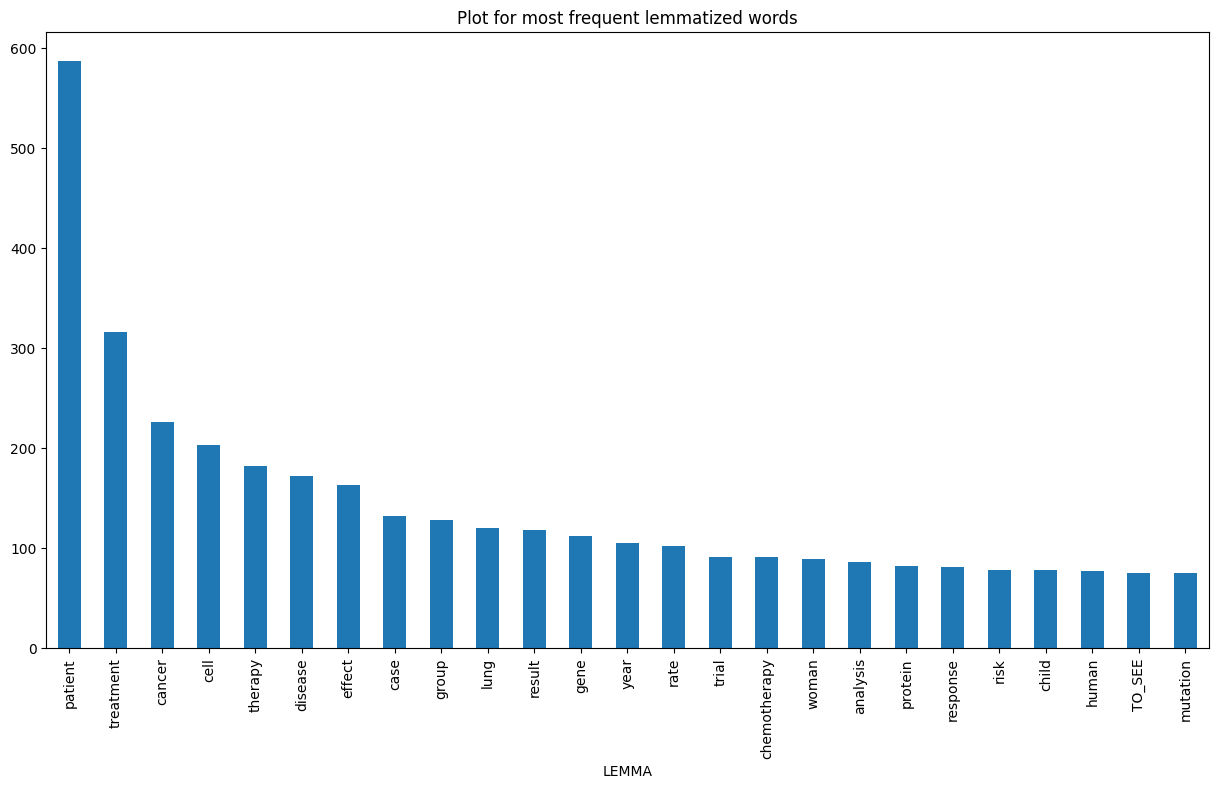

In [19]:
plt.figure(figsize=(15,8)) 
ax = top_25_lemma.plot.bar()
ax.set_title('Plot for most frequent lemmatized words')
plt.show()

### Observation based on plots-

Looking at the plots, we could conclude that:
- most dataset is for cancer, chemotherapy 
- data shows disease mostly in women and child
- most common organ affected is lung

###### Train dataframe with tokens

In [20]:
train_df.head()

,SENTENCE,WORD,POS,LEMMA,LABEL
0,1,All,PRON,all,O
1,1,live,VERB,live,O
2,1,births,NOUN,birth,O
3,1,>,PUNCT,>,O
4,1,or,CCONJ,or,O


##### Test dataframe with tokens

In [21]:
test_df.head()

,SENTENCE,WORD,POS,LEMMA,LABEL
0,1,Furthermore,ADV,furthermore,O
1,1,",",PUNCT,",",O
2,1,when,SCONJ,when,O
3,1,all,PRON,all,O
4,1,deliveries,NOUN,delivery,O


##### Checkig combined dataframe from train and test dataset

In [22]:
print(df.describe())
print(df.head())

                    sentences   labels
count                    3655     3655
unique                   3567     1614
top     Mutations in brief no  O O O O
freq                       17       96
                                           sentences   
0  All live births > or = 23 weeks at the Univers...  \
1  The total cesarean rate was 14.4 % ( 344 of 23...   
2  Abnormal presentation was the most common indi...   
3  The `` corrected '' cesarean rate ( maternal-f...   
4  Arrest of dilation was the most common indicat...   

                                              labels  
0  O O O O O O O O O O O O O O O O O O O O O O O ...  
1  O O O O O O O O O O O O O O O O O O O O O O O O O  
2                      O O O O O O O O O O O O O O O  
3  O O O O O O O O O O O O O O O O O O O O O O O ...  
4        O O O O O O O O O O O O O O O O O O O O O O  


In [23]:
# Creating new columns which is the total number of O tags, D tags and T tags in a sentence/document

df['O_label']=df.labels.apply(lambda x: len(re.findall('O',x))) # Get total number of O labels in the given sentence
df['D_label']=df.labels.apply(lambda x: len(re.findall('D',x))) # Get total number of D labels in the given sentence
df['T_label']=df.labels.apply(lambda x: len(re.findall('T',x))) # Get total number of T labels in the given sentence
df.head(5) # Checking the first 5 rows from the dataframe

,sentences,labels,O_label,D_label,T_label
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...,45,0,0
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O,25,0,0
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O,15,0,0
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...,38,0,0
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O,22,0,0


In [24]:
df.describe()

,O_label,D_label,T_label
count,3655.000000,3655.000000,3655.000000
mean,15.269494,1.337620,1.045417
std,12.396386,2.109442,2.377397
min,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000
75%,21.000000,2.000000,1.000000
max,125.000000,34.000000,30.000000


We could see that the number of D labels at 50% quantile is 0. Note that even T labels are 0 at 50% quantile.
This indicates that less than half of the given corpus have the D labels. Similarly, T labels are less than 50%.


In [25]:
df.T_label.sum()

3821

In [26]:
df.O_label.sum()

55810

In [27]:
df.D_label.sum()

4889

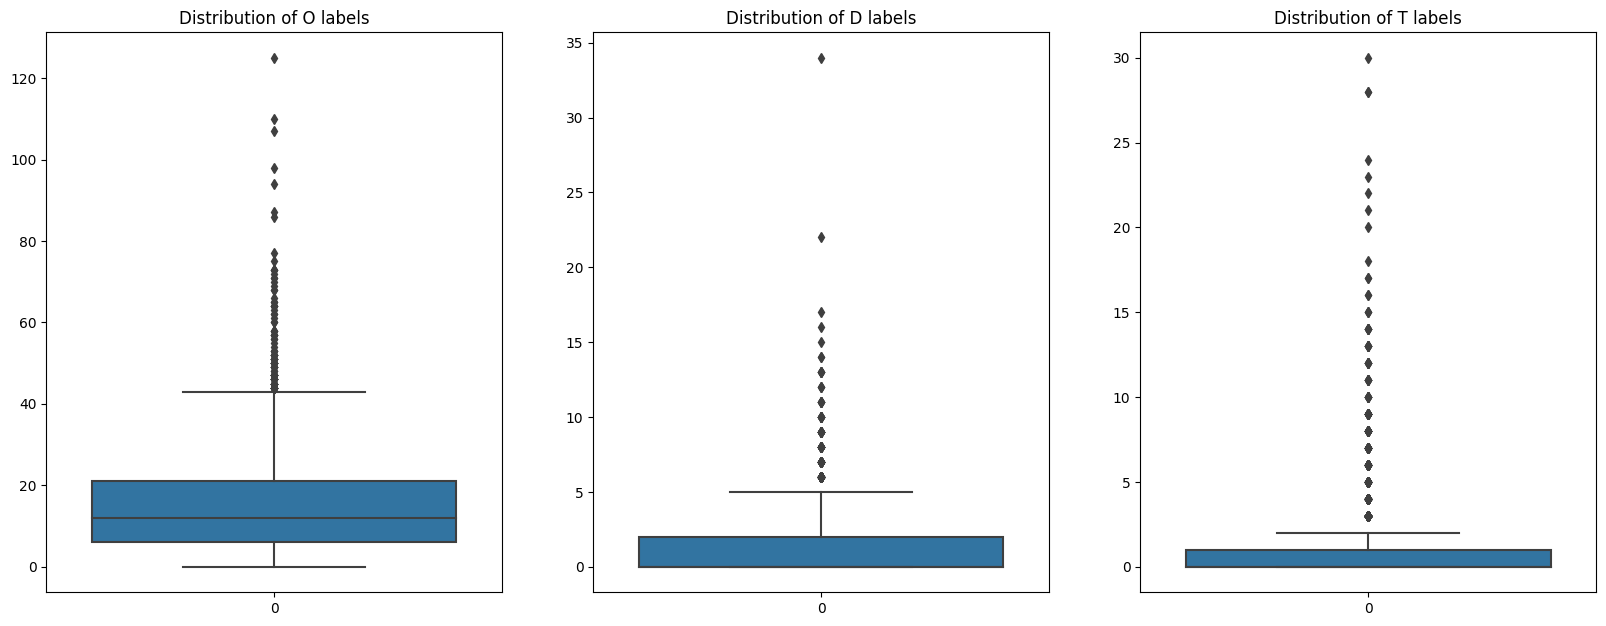

In [28]:

plt.figure(figsize=(20,16))
plt.subplot(2,3,1)
plt.title('Distribution of O labels')
sns.boxplot(df.O_label)
plt.subplot(2,3,2)
plt.title('Distribution of D labels')
sns.boxplot(df.D_label)
plt.subplot(2,3,3)
plt.title('Distribution of T labels')
sns.boxplot(df.T_label)
plt.show()

Based on this, we could observe that the distribution of the O label is above 120 in a few sentences while its overall range of its values lie roughly around 0 to 40.
We also observe that there are comparatively few sentences that has D labels and even lesser sentences have T labels.

##### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [29]:
noun_propn=[] 
for sent in all_sent: #looping through all sentences i.e. train and test sentences
    doc=model(sent) # applying the NLP model on each sentence
    for token in doc: # Looping through the tokens created by the model
        if token.pos_=='NOUN' or token.pos_=='PROPN': # Checking if the pos_ tag is 'NOUN' or 'PROPN' 
            noun_propn.append(token.lemma_.lower()) # add to the list

In [30]:
##### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [31]:
pd.Series(noun_propn).value_counts().head(25)

patient         568
treatment       316
%               247
study           236
cancer          226
cell            203
therapy         182
effect          181
disease         170
group           145
case            132
result          121
lung            120
gene            111
year            105
rate            103
use              91
chemotherapy     91
trial            90
woman            89
conclusion       89
analysis         86
protein          82
response         81
risk             78
Name: count, dtype: int64

In [32]:
print(len(noun_propn))

24373


##### We could see here that we have 24,327 words that have parts of speech (PoS) tag of nouns or proper nouns from our model.

## Defining features for CRF

In [33]:
# Let's define the features to get the feature value for one word.

def getfeatures_for_oneword(sentence, pos, pos_tags):
    """
    Docstring - to be updated
    """
    word = sentence[pos]
    features = [
    'word.lower=' + word.lower(), # id for the word
    'word[-2:]=' + word[-2:],     # last 2 characters
    'word[-3:]=' + word[-3:],     # last 3 characters
    'word.isupper=%s' % word.isupper(),  # is uppercase
    'word.isdigit=%s' % word.isdigit(),  # is number
    'word.startsWithCapital=%s' % word[0].isupper(), # starts with Capital
    'word.pos=' + pos_tags[pos], # pos tag
    'word.pos_isnoun=%s' % (pos_tags[pos] in ['NOUN','PROPN'])
    ]

    # previous word features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1],
        'prev_word.pos_isnoun=%s' % (pos_tags[pos] in ['NOUN','PROPN'])
        ])
    # marking beginning and end of sentences
    else:
        features.append('BEG') # feature for beginning of sentence

    if(pos == len(sentence)-1):
        features.append('END') # feature for end of sentence

    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [34]:
# Write a code to get features for a sentence.
def getfeatures_for_onesentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    tokenized_sentence = nlp(sentence)
    postags = []
    
    for token in tokenized_sentence:
        postags.append(token.pos_)
    
    sentence_list = sentence.split()
    getfeatures = []
    for pos in range(len(sentence_list)):
        getfeatures.append(getfeatures_for_oneword(sentence_list, pos, postags))
    #getfeatures = [getfeatures_for_oneword(sentence_list, pos, postags) for pos in range(len(sentence_list))]
    return getfeatures

### Write a code/function to get the labels of a sentence

In [35]:
# Write a code to get the labels for a sentence.
def getlabels_for_onesentence(labels):
    return labels.split()

##### Testing getfeatures_for_onesentence in training dataset

In [36]:
# Testing on first statement from training dataset
test_statement = train_sent_processed[0] 
print("First statement from training dataset:")
print(test_statement + "\n")

features = getfeatures_for_onesentence(test_statement)

# Testing if features are extracted correctly for 1st word in first sentence of train dataset
print("First word in first sentence of train dataset:")
print(features[0])

First statement from training dataset:
All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )

First word in first sentence of train dataset:
['word.lower=all', 'word[-2:]=ll', 'word[-3:]=All', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'word.pos=DET', 'word.pos_isnoun=False', 'BEG']


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [37]:
X_train = [getfeatures_for_onesentence(sentence) for sentence in train_sent_processed]
X_test = [getfeatures_for_onesentence(sentence) for sentence in test_sent_processed]

In [38]:
# Checking X_train and X_test for first sentence for intial 4 words
print("First 4 words from first statement from training data:")
print(X_train[0][:4])
print("\n" + "First 4 words from first statement from testing data:")
print(X_test[0][:4])

First 4 words from first statement from training data:
[['word.lower=all', 'word[-2:]=ll', 'word[-3:]=All', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'word.pos=DET', 'word.pos_isnoun=False', 'BEG'], ['word.lower=live', 'word[-2:]=ve', 'word[-3:]=ive', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=ADJ', 'word.pos_isnoun=False', 'prev_word.lower=all', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=True', 'prev_word.pos=DET', 'prev_word.pos_isnoun=False'], ['word.lower=births', 'word[-2:]=hs', 'word[-3:]=ths', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=NOUN', 'word.pos_isnoun=True', 'prev_word.lower=live', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=False', 'prev_word.pos=ADJ', 'prev_word.pos_isnoun=True'], ['word.lower=>', 'word[-2:]=>', 'word[-3:]=>', 'word.isupper=False', 'word.isdigit=False', 'wor

### Define the labels as the target variable for test and the train dataset

In [39]:
Y_train = [getlabels_for_onesentence(labels) for labels in train_label_processed]
Y_test = [getlabels_for_onesentence(labels) for labels in test_label_processed]

In [40]:
# Checking X_train and X_test labels for first sentence for intial 4 words
print("First 4 labels from first statement from training data:")
print(Y_train[0][:4])
print("\n" + "First 4 labels from first statement from testing data:")
print(Y_test[0][:4])

First 4 labels from first statement from training data:
['O', 'O', 'O', 'O']

First 4 labels from first statement from testing data:
['O', 'O', 'O', 'O']


## Build the CRF Model

### Building the CRF model with max iteration of 100

In [41]:
# Regularization terma c1 and c2 are chosen as 1.0 and 0.01 after many experimentation for the best results based on F1 score
crf = CRF(max_iterations=100, c1=1.0, c2=0.01, all_possible_transitions=False)

# fit the model
if hasattr(crf, 'fit'):
    crf.fit(X_train, Y_train)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [42]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [43]:
# f1 score using the test data
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print(f'F1-score for Medical NER Dataset : {(round(f1_score*100,2))}')

F1-score for Medical NER Dataset : 91.57


In [44]:
# Calculate the f1 score using the test data
precision = metrics.flat_precision_score(Y_test, Y_pred, average='weighted')
recall  = metrics.flat_recall_score(Y_test, Y_pred, average='weighted')
accuracy = metrics.flat_accuracy_score(Y_test, Y_pred)
print(f'Precision score for Medical NER Dataset : {(round(precision*100,2))}')
print(f'Recall score for Medical NER Dataset : {(round(recall*100,2))}')
print(f'Accuracy score for Medical NER Dataset : {(round(accuracy*100,2))}')

Precision score for Medical NER Dataset : 91.54
Recall score for Medical NER Dataset : 92.16
Accuracy score for Medical NER Dataset : 92.16


## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

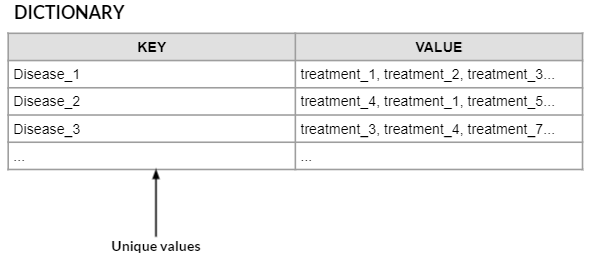

In [45]:
# First value from Y_pred
print(Y_pred[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [46]:
# Creating dictionary for the diseases and recommended Treatments for the same
disease_treatment = {}

for i in range(len(Y_pred)):  

    # tag of each sentence as per prediction
    DTO_tag = Y_pred[i]
    diseases = ""
    treatments = ""
    
    # Iterating over DTO tag of each word in a sentence
    # to obtain Disease and Treatment from it
    for j in range(len(DTO_tag)):
        if DTO_tag[j] == 'D': # for obtaining Disease
            diseases += test_sent_processed[i].split()[j] + " "
        elif DTO_tag[j] == 'T': # for obtaining Treatment
            treatments += test_sent_processed[i].split()[j] + " "
            
    # Removing extra white space
    diseases = diseases.lstrip().rstrip()
    treatments = treatments.lstrip().rstrip()

    # Adding disease and treatments to disease_treatment map
    if diseases != "" and treatments != "":
        if diseases in disease_treatment.keys(): # disease key already present
            treatment_out = list([diseases])
            treatment_out.append(treatments)   # append treatment
            disease_treatment[diseases] = treatment_out
        elif diseases not in disease_treatment.keys(): # adding disease and treatment if not present in dictionary
            disease_treatment[diseases] = treatments

##### Checking few records from disease_treatment dictionary

In [47]:
disease_treatment_df = pd.DataFrame(columns=['disease','treatment'])
i = 0
for k, v in disease_treatment.items():
    l = [k, v]
    disease_treatment_df.loc[len(disease_treatment_df.index)] = l
disease_treatment_df.head(5)

,disease,treatment
0,gestational diabetes,good glycemic control
1,hereditary retinoblastoma,radiotherapy
2,epilepsy,Methylphenidate
3,unstable angina or non-Q-wave myocardial infar...,roxithromycin
4,coronary-artery disease,Antichlamydial antibiotics


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [48]:
disease = 'hereditary retinoblastoma'
print("Treatment for the disease '"+ disease + "' : '"+ disease_treatment[disease]+"'")

Treatment for the disease 'hereditary retinoblastoma' : 'radiotherapy'


#### Hence we conclude that the treatment for the disease 'heriditary retinoblastoma' is'radiotherapy'.